# Import necessary libraries

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_palette("Set2")
%matplotlib inline

#Data Loading and Understanding

### Load all datasets

In [23]:
import zipfile
import os

# List of zip files to extract
zip_files = [
    'orders.csv.zip',
    'products.csv.zip',
    'order_products__prior.csv.zip',
    'order_products__train.csv.zip'
]

# Directory to extract to (optional, defaults to current directory)
extract_dir = '.'

# Extract each zip file
for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

# Now load the extracted CSV files
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv', on_bad_lines='skip')

## Display basic information

In [24]:
print("Dataset Shapes:")
print(f"Orders: {orders.shape}")
print(f"Order Products Prior: {order_products_prior.shape}")
print(f"Order Products Train: {order_products_train.shape}")
print(f"Products: {products.shape}")

Dataset Shapes:
Orders: (3421083, 7)
Order Products Prior: (32434489, 4)
Order Products Train: (1384617, 4)
Products: (49688, 4)


### Explore the data

In [25]:
# Merge product information
products = products.merge(aisles, on='aisle_id').merge(departments, on='department_id')

print("\nOrders dataset preview:")
print(orders.head())
print("\nOrders eval_set value counts:")
print(orders.eval_set.value_counts())


Orders dataset preview:
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  

Orders eval_set value counts:
eval_set
prior    3214874
train     131209
test       75000
Name: count, dtype: int64


#Data Preprocessing and Feature Engineering

### Create user-level features

In [26]:
def create_user_features(orders_df):
    user_features = orders_df[orders_df.eval_set == 'prior'].groupby('user_id').agg({
        'order_number': 'max',
        'days_since_prior_order': ['mean', 'std', 'sum']
    }).reset_index()

    user_features.columns = ['user_id', 'user_total_orders',
                            'user_avg_days_between_orders',
                            'user_std_days_between_orders',
                            'user_total_days']
    return user_features

##
# Create product-level features

In [27]:
def create_product_features(order_products_df):
    product_features = order_products_df.groupby('product_id').agg({
        'order_id': 'count',
        'reordered': 'mean',
        'add_to_cart_order': 'mean'
    }).reset_index()

    product_features.columns = ['product_id', 'product_total_orders',
                               'product_reorder_rate',
                               'product_avg_cart_position']
    return product_features

## Create user-product interaction features

In [28]:
def create_user_product_features(orders_df, order_products_df):
    # Get prior orders
    prior_orders = orders_df[orders_df.eval_set == 'prior']

    # Merge with order products
    up_features = order_products_df.merge(prior_orders[['order_id', 'user_id', 'order_number']],
                                         on='order_id')

    # Calculate user-product features
    up_features = up_features.groupby(['user_id', 'product_id']).agg({
        'order_id': 'count',
        'add_to_cart_order': 'mean',
        'reordered': 'sum',
        'order_number': ['min', 'max']
    }).reset_index()

    up_features.columns = ['user_id', 'product_id', 'up_order_count',
                          'up_avg_cart_position', 'up_reorder_count',
                          'up_first_order', 'up_last_order']

    return up_features

## Create time-based features

In [29]:
def create_time_features(orders_df, order_products_df):
    prior_orders = orders_df[orders_df.eval_set == 'prior'][['order_id', 'user_id', 'order_number', 'days_since_prior_order']]
    up_orders = order_products_df.merge(prior_orders, on='order_id')

    # Calculate days since last order for each product
    last_order_days = up_orders.groupby(['user_id', 'product_id'])['days_since_prior_order'].sum().reset_index()
    last_order_days.columns = ['user_id', 'product_id', 'up_days_since_first_order']

    return last_order_days

## Create all features

In [30]:
user_features = create_user_features(orders)
product_features = create_product_features(order_products_prior)
up_features = create_user_product_features(orders, order_products_prior)
time_features = create_time_features(orders, order_products_prior)

#Create Training Dataset

##Prepare the target variable from train set

In [31]:
train_orders = orders[orders.eval_set == 'train'][['user_id', 'order_id']]
train_data = order_products_train.merge(train_orders, on='order_id')

## Create target variable: 1 if reordered, 0 otherwise

In [32]:
target = train_data[['user_id', 'product_id', 'reordered']]
target.columns = ['user_id', 'product_id', 'target']

## Create the main dataset by combining all features

In [33]:
dataset = up_features.merge(user_features, on='user_id')
dataset = dataset.merge(product_features, on='product_id')
dataset = dataset.merge(time_features, on=['user_id', 'product_id'])

## Add additional calculated features

In [34]:
dataset['up_order_rate'] = dataset['up_order_count'] / dataset['user_total_orders']
dataset['up_reorder_rate'] = dataset['up_reorder_count'] / dataset['up_order_count'].replace(0, 1)
dataset['up_orders_since_last'] = dataset['user_total_orders'] - dataset['up_last_order']

## Merge with target

In [35]:
dataset = dataset.merge(target, on=['user_id', 'product_id'], how='left')
dataset['target'] = dataset['target'].fillna(0).astype(int)

print(f"Final dataset shape: {dataset.shape}")
print(f"Target distribution:\n{dataset['target'].value_counts()}")
print(f"Target percentage: {dataset['target'].mean():.2%}")

Final dataset shape: (13307953, 19)
Target distribution:
target
0    12479129
1      828824
Name: count, dtype: int64
Target percentage: 6.23%


#Exploratory Data Analysis

## Plot target distribution

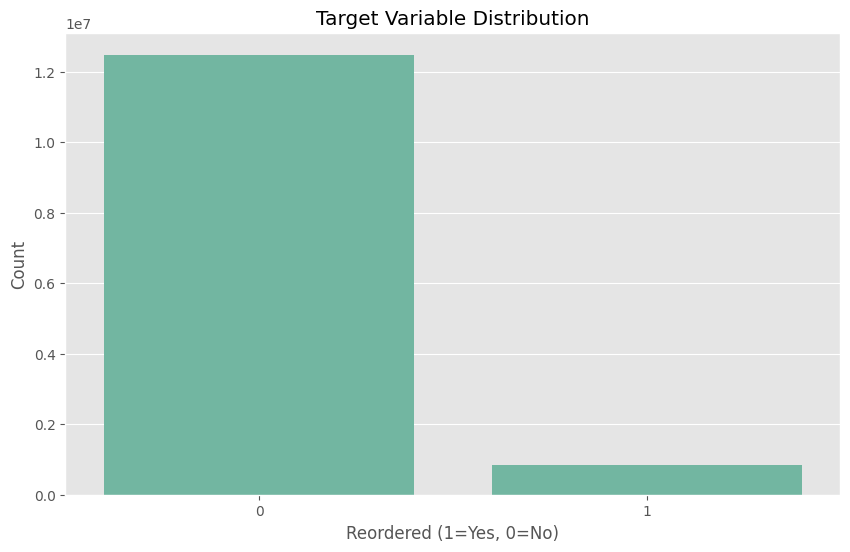

In [36]:
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=dataset)
plt.title('Target Variable Distribution')
plt.xlabel('Reordered (1=Yes, 0=No)')
plt.ylabel('Count')
plt.show()

## Correlation matrix for numerical features

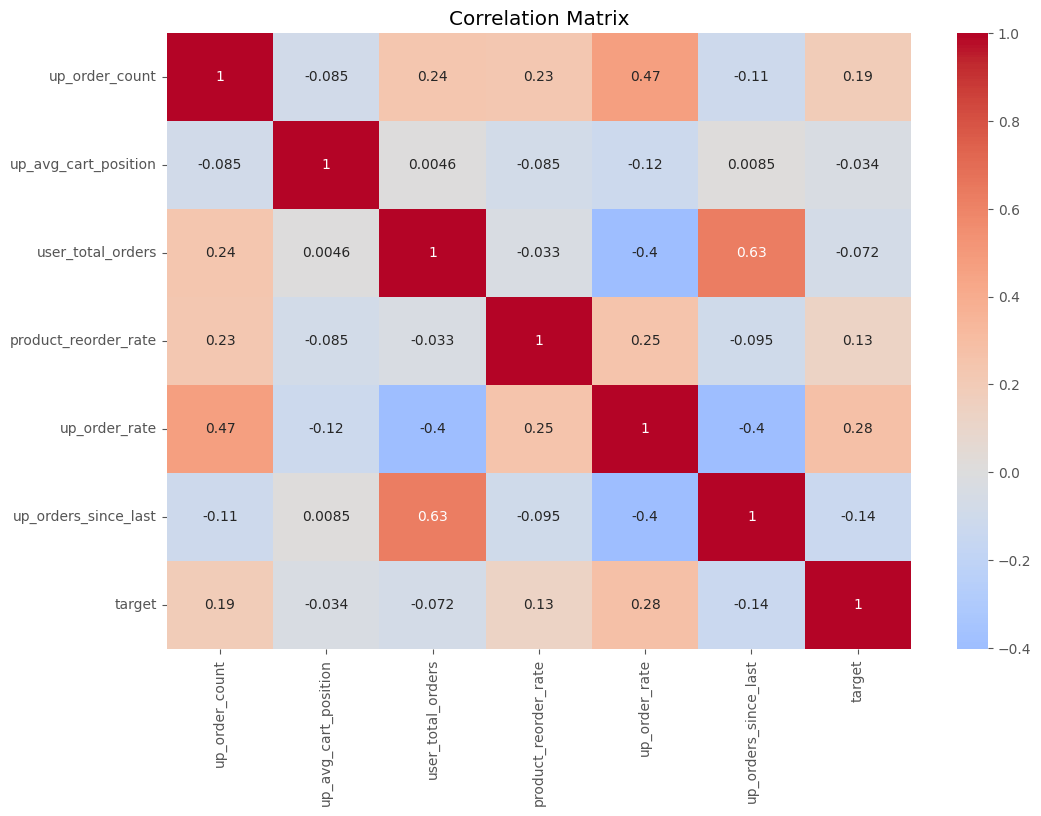

In [37]:
numerical_features = ['up_order_count', 'up_avg_cart_position', 'user_total_orders',
                     'product_reorder_rate', 'up_order_rate', 'up_orders_since_last']

plt.figure(figsize=(12, 8))
corr_matrix = dataset[numerical_features + ['target']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

## Analyze top features by importance (pre-model)

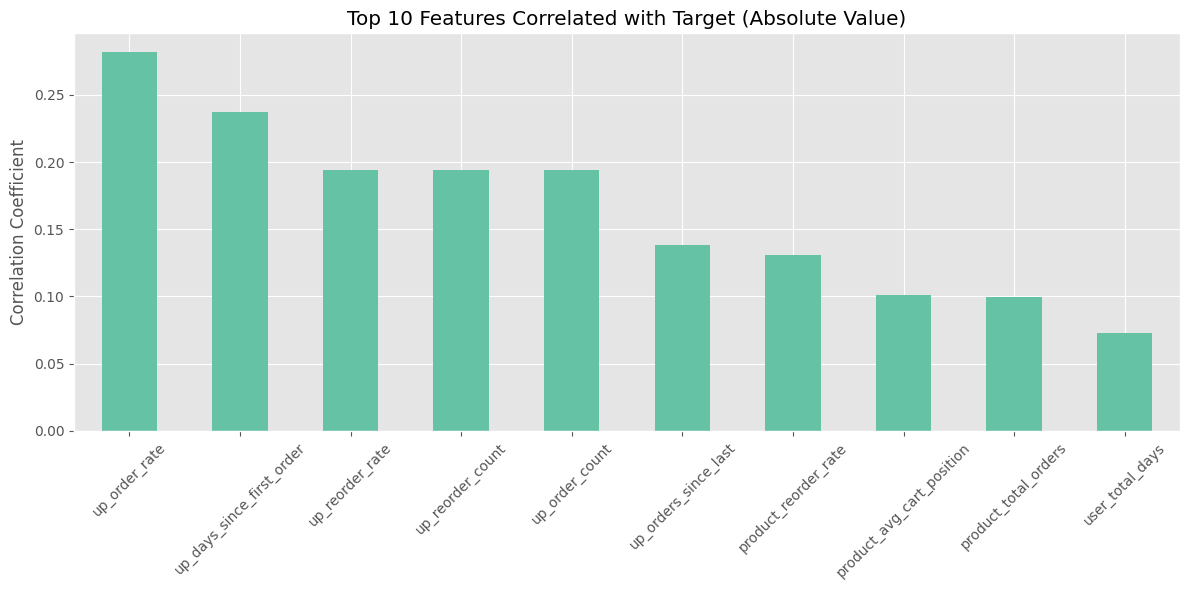

In [38]:
plt.figure(figsize=(12, 6))
feature_correlations = dataset.corr()['target'].abs().sort_values(ascending=False)[1:11]
feature_correlations.plot(kind='bar')
plt.title('Top 10 Features Correlated with Target (Absolute Value)')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Prepare Data for Modeling

## Define features and target

In [39]:
features = ['up_order_count', 'up_avg_cart_position', 'user_total_orders',
           'user_avg_days_between_orders', 'product_total_orders',
           'product_reorder_rate', 'up_order_rate', 'up_reorder_rate',
           'up_orders_since_last', 'up_days_since_first_order']

X = dataset[features]
y = dataset['target']

X = X.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"Positive class in training: {y_train.mean():.2%}")
print(f"Positive class in testing: {y_test.mean():.2%}")

Training set: (10646362, 10)
Testing set: (2661591, 10)
Positive class in training: 6.23%
Positive class in testing: 6.23%


#Build and Train LightGBM Model

## Create LightGBM dataset

In [41]:
train_data_lgb = lgb.Dataset(X_train, label=y_train)
test_data_lgb = lgb.Dataset(X_test, label=y_test, reference=train_data_lgb)


## Define parameters for LightGBM

In [44]:
# Create a callback to save the model every 25 iterations
# checkpoint_callback = lgb.record_evaluation()

params = {
    'objective': 'binary',
    'metric': ['auc', 'binary_logloss'],
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': 7,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1,
    'random_state': 42
}

model = lgb.train(params,
                 train_data_lgb,
                 num_boost_round=200,
                 valid_sets=[test_data_lgb],
                 callbacks=[
                     lgb.early_stopping(stopping_rounds=30, verbose=True)
                 ])

[LightGBM] [Info] Number of positive: 663059, number of negative: 9983303
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.968816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 10646362, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062280 -> initscore=-2.711805
[LightGBM] [Info] Start training from score -2.711805
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.816029	valid_0's binary_logloss: 0.190773


## Make predictions

In [47]:
y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = (y_pred_proba >= 0.5).astype(int)

##Model Evaluation

## Evaluate the model

In [48]:
print("Model Evaluation:")
print(classification_report(y_test, y_pred))

Model Evaluation:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97   2495826
           1       0.54      0.01      0.03    165765

    accuracy                           0.94   2661591
   macro avg       0.74      0.51      0.50   2661591
weighted avg       0.91      0.94      0.91   2661591



## Confusion Matrix

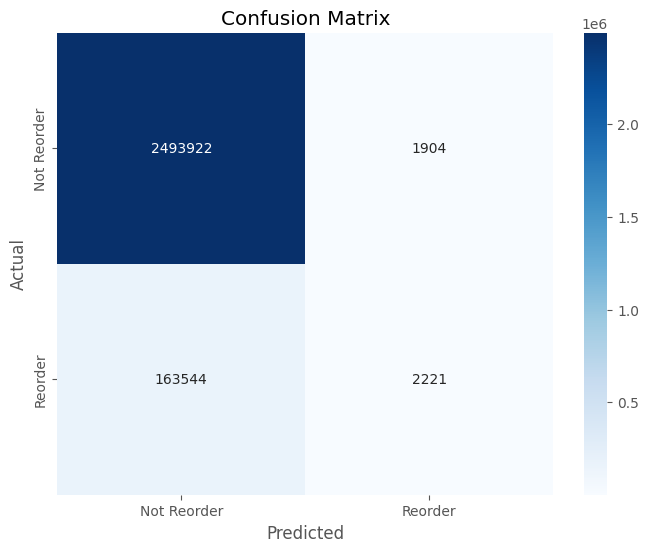

In [49]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Reorder', 'Reorder'],
            yticklabels=['Not Reorder', 'Reorder'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## ROC Curve

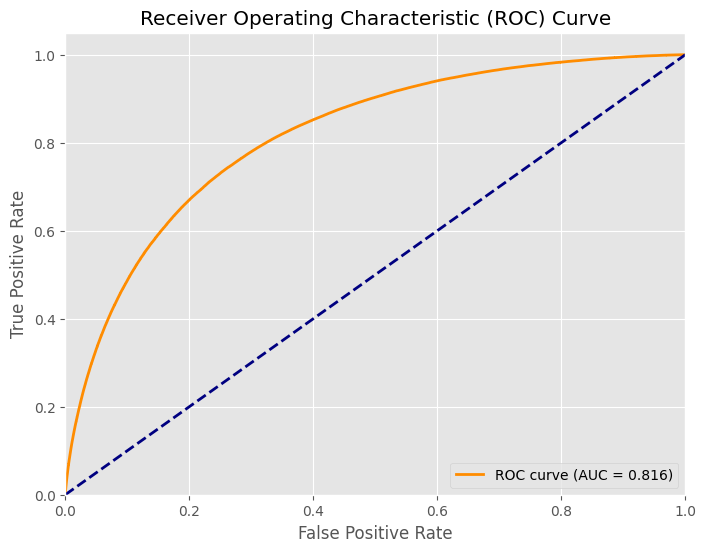

In [50]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Calculate F1 Score

In [51]:
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

F1 Score: 0.0261
ROC AUC Score: 0.8160


#Feature Importance Analysis

## Plot feature importance

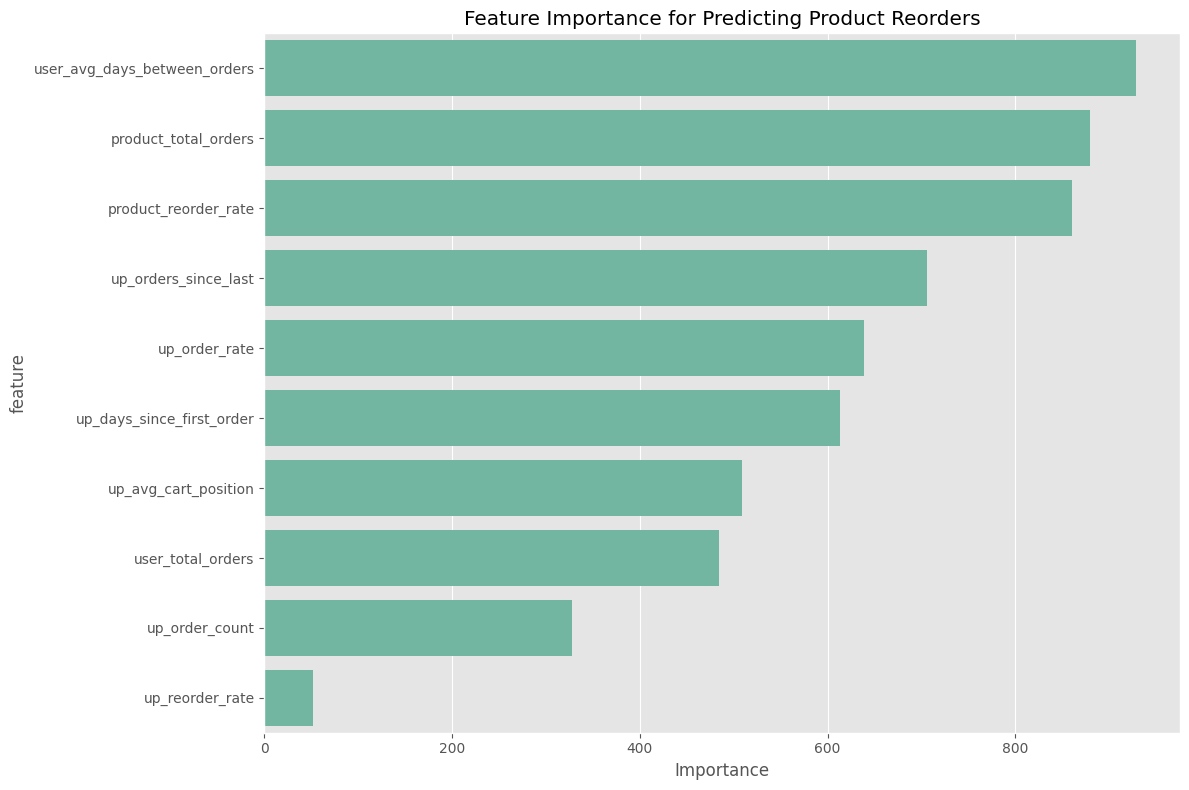

In [52]:
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importance()
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Predicting Product Reorders')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## Display top features with their business interpretation

In [53]:

print("Top Features Influencing Reorder Prediction:")
for idx, row in feature_importance.head(10).iterrows():
    effect = "increases" if dataset[[row['feature'], 'target']].corr().iloc[0,1] > 0 else "decreases"
    print(f"{row['feature']}: {effect} reorder likelihood (importance: {row['importance']})")

Top Features Influencing Reorder Prediction:
user_avg_days_between_orders: increases reorder likelihood (importance: 929)
product_total_orders: increases reorder likelihood (importance: 880)
product_reorder_rate: increases reorder likelihood (importance: 860)
up_orders_since_last: decreases reorder likelihood (importance: 706)
up_order_rate: increases reorder likelihood (importance: 639)
up_days_since_first_order: increases reorder likelihood (importance: 613)
up_avg_cart_position: decreases reorder likelihood (importance: 509)
user_total_orders: decreases reorder likelihood (importance: 484)
up_order_count: increases reorder likelihood (importance: 328)
up_reorder_rate: increases reorder likelihood (importance: 52)


## Plot feature importance

In [54]:
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importance()
})
feature_importance = feature_importance.sort_values('importance', ascending=False)


#Business Insights and Recommendations python


## Generate business insights

## Insight 1: The "Last Purchase" Effect

In [56]:
up_orders_since_last_corr = dataset[['up_orders_since_last', 'target']].corr().iloc[0,1]
print(f"\n1. The 'Last Purchase' Effect:")
print(f"   - Correlation between 'orders since last purchase' and reorder: {up_orders_since_last_corr:.3f}")
print(f"   - INSIGHT: The fewer orders since last purchase, the higher the likelihood of reordering.")
print(f"   - RECOMMENDATION: Target users who haven't purchased an item in 2-3 orders for reminders.")



1. The 'Last Purchase' Effect:
   - Correlation between 'orders since last purchase' and reorder: -0.138
   - INSIGHT: The fewer orders since last purchase, the higher the likelihood of reordering.
   - RECOMMENDATION: Target users who haven't purchased an item in 2-3 orders for reminders.


## Insight 2: Order Rate Importance

In [57]:
print(f"\n2. User Order Habits:")
print(f"   - 'up_order_rate' is the #{feature_importance[feature_importance['feature'] == 'up_order_rate'].index[0] + 1} most important feature")
print(f"   - INSIGHT: Users develop strong habits with specific products.")
print(f"   - RECOMMENDATION: Create a 'Favorites' section for high order-rate products.")


2. User Order Habits:
   - 'up_order_rate' is the #7 most important feature
   - INSIGHT: Users develop strong habits with specific products.
   - RECOMMENDATION: Create a 'Favorites' section for high order-rate products.


## Insight 3: Cart Position Matters

In [58]:
cart_pos_corr = dataset[['up_avg_cart_position', 'target']].corr().iloc[0,1]
print(f"\n3. Cart Position Analysis:")
print(f"   - Correlation between cart position and reorder: {cart_pos_corr:.3f}")
print(f"   - INSIGHT: Products added earlier in the cart are more likely to be reordered.")
print(f"   - RECOMMENDATION: Prioritize showing frequently purchased items first.")


3. Cart Position Analysis:
   - Correlation between cart position and reorder: -0.034
   - INSIGHT: Products added earlier in the cart are more likely to be reordered.
   - RECOMMENDATION: Prioritize showing frequently purchased items first.


## Insight 4: Product Reorder Rates

In [59]:
product_reorder_stats = dataset.groupby('target')['product_reorder_rate'].mean()
print(f"\n4. Product-Level Behavior:")
print(f"   - Mean reorder rate for products that were reordered: {product_reorder_stats[1]:.3f}")
print(f"   - Mean reorder rate for products not reordered: {product_reorder_stats[0]:.3f}")
print(f"   - INSIGHT: Some products have inherently higher reorder rates (e.g., staples).")
print(f"   - RECOMMENDATION: Identify high-reorder-rate products for promotional bundling.")


4. Product-Level Behavior:
   - Mean reorder rate for products that were reordered: 0.617
   - Mean reorder rate for products not reordered: 0.529
   - INSIGHT: Some products have inherently higher reorder rates (e.g., staples).
   - RECOMMENDATION: Identify high-reorder-rate products for promotional bundling.


## Calculate potential business impact

In [60]:
# Recalculate f1 score as it might not be available in the current scope
f1 = f1_score(y_test, (model.predict(X_test, num_iteration=model.best_iteration) >= 0.5).astype(int))
total_users = dataset['user_id'].nunique()
potential_improvement = f1 * 0.2  # Assuming 20% of correct predictions lead to additional sales

print(f"\n5. Potential Business Impact:")
print(f"   - Model F1 Score: {f1:.3f}")
print(f"   - Unique users in dataset: {total_users:,}")
print(f"   - Estimated additional sales potential: {potential_improvement * 100:.1f}% increase")
print(f"   - RECOMMENDATION: Implement personalized recommendations based on this model.")


5. Potential Business Impact:
   - Model F1 Score: 0.026
   - Unique users in dataset: 206,209
   - Estimated additional sales potential: 0.5% increase
   - RECOMMENDATION: Implement personalized recommendations based on this model.


# Create Prediction Function for Demonstration

## Function to predict reorders for a specific user

In [61]:
def predict_user_reorders(user_id, top_n=10):
    """Predict top N products a user is most likely to reorder"""
    user_data = dataset[dataset['user_id'] == user_id]

    if user_data.empty:
        return "User ID not found in dataset"

    # Get features for prediction
    X_user = user_data[features].fillna(0)

    # Predict probabilities
    user_data['reorder_probability'] = model.predict(X_user, num_iteration=model.best_iteration)

    # Get top predictions
    top_products = user_data.nlargest(top_n, 'reorder_probability')[['product_id', 'reorder_probability', 'up_order_count', 'up_orders_since_last']]

    # Merge with product names
    top_products = top_products.merge(products[['product_id', 'product_name', 'department']], on='product_id')

    return top_products[['product_name', 'department', 'reorder_probability', 'up_order_count', 'up_orders_since_last']]

## Example prediction for a user

In [62]:
print("\nExample Prediction for User #1:")
example_prediction = predict_user_reorders(1, top_n=5)
print(example_prediction)


Example Prediction for User #1:
            product_name  department  reorder_probability  up_order_count  \
0                   Soda   beverages             0.542295              10   
1    Original Beef Jerky      snacks             0.497415              10   
2             Pistachios      snacks             0.454419               9   
3  Organic String Cheese  dairy eggs             0.425355               8   
4      Zero Calorie Cola   beverages             0.274994               3   

   up_orders_since_last  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  


##Save the model for future use

In [63]:
model.save_model('instacart_recommendation_model.txt')
print("\nModel saved successfully as 'instacart_recommendation_model.txt'")


Model saved successfully as 'instacart_recommendation_model.txt'
